In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      transforms.ColorJitter(brightness=0.40, contrast=0.4, saturation=0.40, hue=0.1),
                                      transforms.RandomAffine(degrees=7, shear=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                      transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                      transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolution block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3,bias=False), # 16,26,26
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.04),
            nn.Conv2d(8, 16, 3,bias=False), # 16,24,24
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.04)
        )
        # transition block 1
        self.trans_block1 = nn.Sequential(
            nn.Conv2d(16, 8, 1,bias=False), # 8,24,24 - reduce channels
            nn.MaxPool2d(2, 2),  # 8,12,12 - reduce output
        )
        # convolution block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 3,bias=False), # 8,10,10
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.04),
            nn.Conv2d(16, 16, 3,bias=False), # 8,8,8
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.04),
            nn.Conv2d(16, 16, 3,bias=False), # 8,6,6
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05)
        )
        # final block
        self.final_block = nn.Sequential(
            nn.AvgPool2d(kernel_size=6), # 10
            nn.Conv2d(16,10,1,bias=False), # 10,6,6
            #nn.Conv2d(20,10,1), # 10,6,6
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.trans_block1(x)
        x = self.conv2(x)
        x = self.final_block(x)
        x = x.view(-1,10)
        return F.log_softmax(x, dim=-1)

In [6]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1, 16,

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
    return correct / len(test_loader.dataset)

In [8]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max',patience=3)
scheduler = StepLR(optimizer, step_size=8, gamma=0.1)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test_accuracy = test(model, device, test_loader)
    #scheduler.step(test_accuracy)

EPOCH: 0


Loss=0.2038557082414627 Batch_id=468 Accuracy=79.56: 100%|██████████| 469/469 [00:45<00:00, 10.35it/s]



Test set: Average loss: 0.0946, Accuracy: 9722/10000 (97.22%)

EPOCH: 1


Loss=0.12626726925373077 Batch_id=468 Accuracy=95.40: 100%|██████████| 469/469 [00:44<00:00, 10.49it/s]



Test set: Average loss: 0.0513, Accuracy: 9854/10000 (98.54%)

EPOCH: 2


Loss=0.19785475730895996 Batch_id=468 Accuracy=96.56: 100%|██████████| 469/469 [00:47<00:00,  9.92it/s]



Test set: Average loss: 0.0369, Accuracy: 9897/10000 (98.97%)

EPOCH: 3


Loss=0.14512433111667633 Batch_id=468 Accuracy=96.86: 100%|██████████| 469/469 [00:44<00:00, 10.53it/s]



Test set: Average loss: 0.0314, Accuracy: 9900/10000 (99.00%)

EPOCH: 4


Loss=0.06599081307649612 Batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:44<00:00, 10.43it/s]



Test set: Average loss: 0.0290, Accuracy: 9909/10000 (99.09%)

EPOCH: 5


Loss=0.1065826416015625 Batch_id=468 Accuracy=97.60: 100%|██████████| 469/469 [00:44<00:00, 10.55it/s]



Test set: Average loss: 0.0251, Accuracy: 9927/10000 (99.27%)

EPOCH: 6


Loss=0.06128755211830139 Batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [00:44<00:00, 10.63it/s]



Test set: Average loss: 0.0248, Accuracy: 9921/10000 (99.21%)

EPOCH: 7


Loss=0.05164946988224983 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:48<00:00,  9.76it/s]



Test set: Average loss: 0.0209, Accuracy: 9939/10000 (99.39%)

EPOCH: 8


Loss=0.0657762736082077 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:45<00:00, 10.40it/s]



Test set: Average loss: 0.0191, Accuracy: 9942/10000 (99.42%)

EPOCH: 9


Loss=0.12255439162254333 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:46<00:00, 10.10it/s]



Test set: Average loss: 0.0192, Accuracy: 9940/10000 (99.40%)

EPOCH: 10


Loss=0.0528000146150589 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:45<00:00, 10.31it/s]



Test set: Average loss: 0.0187, Accuracy: 9943/10000 (99.43%)

EPOCH: 11


Loss=0.044033538550138474 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:44<00:00, 10.45it/s]



Test set: Average loss: 0.0189, Accuracy: 9938/10000 (99.38%)

EPOCH: 12


Loss=0.03129389137029648 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:47<00:00,  9.85it/s]



Test set: Average loss: 0.0184, Accuracy: 9944/10000 (99.44%)

EPOCH: 13


Loss=0.05927780643105507 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:44<00:00, 10.45it/s]



Test set: Average loss: 0.0185, Accuracy: 9941/10000 (99.41%)

EPOCH: 14


Loss=0.01610044203698635 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:45<00:00, 10.29it/s]



Test set: Average loss: 0.0183, Accuracy: 9944/10000 (99.44%)



Text(0.5, 1.0, 'Test Accuracy')

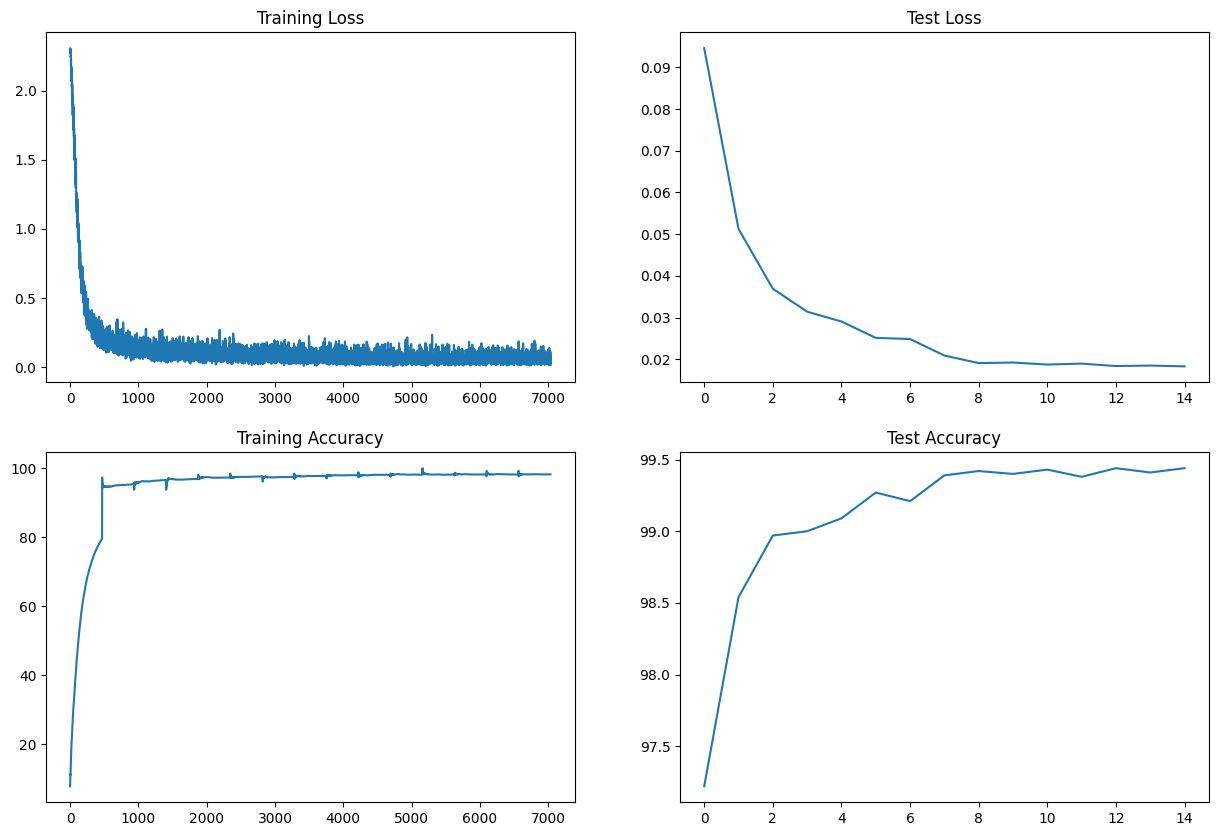

In [9]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")